# 8-9 In Silico Reprogramming to Hematopoietic Stem Cells, Nat O.

In [1]:
import sys
import seaborn as sns
import pandas as pd 
import numpy as np
from itertools import combinations
from scipy.spatial.distance import squareform, pdist
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import torch
import anndata as ad
import scanpy as sc
import os
import gc
from importlib import reload
print("C1")

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor

from sklearn.cluster import KMeans
print("C2")

#classifer tools
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
print("C3")

sns.set_style('white')
torch.cuda.empty_cache()

import os

from datasets import Dataset, load_from_disk, load_dataset
import geneformer

from datetime import datetime
print("C4")
DEFAULT_NAME_PATH = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer/gene_name_id_dict.pkl"
DEFAULT_TOKEN_PATH = "/nfs/turbo/umms-indikar/shared/projects/geneformer/token_dictionary.pkl"
DEFAULT_MEDIAN_PATH = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer/gene_median_dictionary.pkl"

sns.set_style('white')
torch.cuda.empty_cache()
print("C5")

C1
C2
C3
C4
C5


In [2]:
import scipy
print(f"Scipy version: {scipy.__version__}")


Scipy version: 1.14.0


# Load in the Single Cell Data

## In Silico Perturbed

#### This loads in all the perturbed cells from turbo, which already have k means cluster columns in obs and look nice 

In [128]:
import anndata as ad
reprog_wid_path = '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/' + 'nat_reprog_centroid_adata_all_2'
reprog_centroid_adata_wid = ad.read_h5ad(reprog_wid_path)
# this is not actually written into the file idk if we care? 
reprog_centroid_adata_wid.obs['type'] = 'reprogrammed'
reprog_centroid_adata_wid.obs['cluster_number'] = range(1, len(reprog_centroid_adata_wid.obs) + 1)

reprog_centroid_adata_wid.obs.size

/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


15120

In [4]:
"""
Sometimes the same set of cell_ids shows up duplicated in the list, but if 
it does, there is always a differenct recipe 
Identify the perturbation uniquely by (recipe_number, kmeans_cluster)
"""

'\nSometimes the same set of cell_ids shows up duplicated in the list, but if \nit does, there is always a differenct recipe \nIdentify the perturbation uniquely by (recipe_number, kmeans_cluster)\n'

In [5]:
unique_cell_ids = reprog_centroid_adata_wid.obs['cell_id'].nunique()
print(unique_cell_ids)
print(reprog_centroid_adata_wid.shape)

2509
(2520, 512)


In [6]:

non_unique_cell_ids = reprog_centroid_adata_wid.obs[reprog_centroid_adata_wid.obs.duplicated('cell_id', keep=False)]
truly_non_unique_cell_ids = non_unique_cell_ids[non_unique_cell_ids.duplicated('recipe_name', keep=False)]

# Sort the rows by 'cell_id'
sorted_non_unique_cell_ids = truly_non_unique_cell_ids.sort_values(by='cell_id')

sorted_non_unique_cell_ids.head(20)

# # Display the sorted rows with column headers and proper formatting
# print(sorted_non_unique_cell_ids.to_string(index=False))


,kmeans_cluster,recipe_name,recipe_number,cell_id,type,cluster_number


## Initial Fibroblast

#### Rather than loading in the unperturbed cells, we don't really have them neatly saved to a nice place, except for in some of those files from the slurm job that had them tacked at the top.  Make a separate df of those, from any one of the files that had them.

In [7]:
# Just pick from a random file where they were copied (the first half ish of them have them still in original). Then filter by type

harvest_file_path = '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/originals/2024-07-31_03-49-01_job_number_22.h5ad'
harvest_file_adata = ad.read_h5ad(harvest_file_path)
initial_adata = harvest_file_adata[harvest_file_adata.obs['type'] == 'initial']

initial_adata.obs.sample(10)


/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,input_ids,cell_type,dataset,length,ignore,standardized_cell_type,broad_type,__index_level_0__,cell_id,recipe,type
7073,[ 9009 18367 16916 ... 2549 2214 7153],Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,154294,cell_7074,raw,initial
10125,[ 1513 16916 12908 ... 10002 8850 1436],Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,160835,cell_10126,raw,initial
13223,[16916 5675 454 ... 4640 14969 327],Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,167474,cell_13224,raw,initial
5936,[ 1732 16916 9009 ... 5749 5021 3475],Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,151842,cell_5937,raw,initial
1396,[ 9009 12119 1860 ... 15481 8399 6292],fibroblast,TS_Vasculature,2048,fibroblast,Fibroblast,fibroblast,113581,cell_1397,raw,initial
4325,[16345 13048 9009 ... 6479 8778 3442],fibroblast,TS_Vasculature,2048,fibroblast,Fibroblast,fibroblast,121562,cell_4326,raw,initial
14833,[16916 19437 20760 ... 1634 19797 8421],Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,170925,cell_14834,raw,initial
9285,[ 9009 16916 220 ... 3891 6736 17335],Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,159072,cell_9286,raw,initial
9904,[16916 9009 4724 ... 8500 11880 1055],Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,160364,cell_9905,raw,initial
2535,[ 1950 16916 16876 ... 8751 15245 8557],fibroblast,TS_Vasculature,2048,fibroblast,Fibroblast,fibroblast,116643,cell_2536,raw,initial


In [8]:
# get adata up and working
# Ensure hsc_adata is already defined and populated with data

# 1. Check the contents of the original obs
print("Original obs contents:")
print(initial_adata.obs.head())

# 2. Create the backup
initial_adata.uns['obs_backup'] = initial_adata.obs.copy()

# 3. Verify the backup was created correctly
print("Contents of obs_backup after creation:")
print(initial_adata.uns['obs_backup'].head())

# 4. Clear the original obs
initial_adata.obs = pd.DataFrame(index=initial_adata.obs.index)

# 5. Check the contents of the cleared obs and the backup
print("Contents of cleared obs:")
print(initial_adata.obs.head())

print("Contents of obs_backup after clearing original obs:")
print(initial_adata.uns['obs_backup'].head())


Original obs contents:
                                   input_ids   cell_type         dataset  \
0  [16345  9009 13048 ...  9332 13451  5456]  fibroblast  TS_Vasculature   
1  [12119  9190 16876 ... 11232  1132  1022]  fibroblast  TS_Vasculature   
2  [ 3878  9009  4115 ...  4697 10362 12098]  fibroblast  TS_Vasculature   
3  [ 3878 16916 18367 ... 15470  3946  2153]  fibroblast  TS_Vasculature   
4  [ 6196 16916 10920 ...  7629 10148 17125]  fibroblast  TS_Vasculature   

  length      ignore standardized_cell_type  broad_type __index_level_0__  \
0   2048  fibroblast             Fibroblast  fibroblast            109770   
1   2048  fibroblast             Fibroblast  fibroblast            109771   
2   2048  fibroblast             Fibroblast  fibroblast            109774   
3   2048  fibroblast             Fibroblast  fibroblast            109776   
4   2048  fibroblast             Fibroblast  fibroblast            109777   

  cell_id recipe     type  
0  cell_1    raw  initial  
1

/tmp/ipykernel_344113/3223748096.py:9: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  initial_adata.uns['obs_backup'] = initial_adata.obs.copy()


In [9]:
# # We need to define a function to get the k means PREIMAGE: what cluster they map into
# # key is made from reprog 's dataframes, that's why we ran that code first 
# key_df = pd.DataFrame({
#     'recipe_number': reprog_centroid_adata_wid.obs['recipe_number'].copy(),
#     'kmeans_cluster': reprog_centroid_adata_wid.obs['kmeans_cluster'].copy() 
#     })

# key_df.head()


In [10]:

#initial_adata.obs['kmeans_cluster'] = initial_kmeans.labels_
initial_adata.obs['recipe_name'] = np.nan
initial_adata.obs['recipe_number'] = np.nan
initial_adata.obs['cell_id'] = initial_adata.uns['obs_backup']['cell_id']
initial_adata.obs['type'] = 'target'

In [11]:
initial_adata.X.shape

(15308, 512)

## HSC Target

#### Like these other two, we need an anndata object of the true HSC / target cells. This one's obs needs a bit of reformatting though.

In [12]:

hsc_file_path = '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/working_output/hsc_1.h5ad'
hsc_adata = ad.read_h5ad(hsc_file_path)
hsc_adata.X.shape# Ensure hsc_adata is already defined and populated with data


/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(20090, 512)

In [13]:
# 1. Check the contents of the original obs
print("Original obs contents:")
print(hsc_adata.obs.head())

# 2. Create the backup
hsc_adata.uns['obs_backup'] = hsc_adata.obs.copy()

# 3. Verify the backup was created correctly
print("Contents of obs_backup after creation:")
print(hsc_adata.uns['obs_backup'].head())

# 4. Clear the original obs
hsc_adata.obs = pd.DataFrame(index=hsc_adata.obs.index)

# 5. Check the contents of the cleared obs and the backup
print("Contents of cleared obs:")
print(hsc_adata.obs.head())

print("Contents of obs_backup after clearing original obs:")
print(hsc_adata.uns['obs_backup'].head())



hsc_adata.obs['kmeans_cluster'] = np.nan # since intermed step
hsc_adata.obs['recipe_name'] = np.nan
hsc_adata.obs['recipe_number'] = np.nan
hsc_adata.obs['cell_id'] = hsc_adata.uns['obs_backup']['cell_id']
hsc_adata.obs['type'] = 'target'


Original obs contents:
                                   input_ids cell_type              dataset  \
0  [14577 17163 10265 ...   852  1582  6234]       HSC  weng_old1_BMMC_HSPC   
1  [14577  3649 17163 ...  8959  1732 18513]       HSC  weng_old1_BMMC_HSPC   
2  [10062  3659 17163 ...  6349  3387  8304]       HSC  weng_old1_BMMC_HSPC   
3  [17163 10265  7725 ...   512  8919 17997]       HSC  weng_old1_BMMC_HSPC   
4  [14577 10265  1734 ...  1537  1532  4065]       HSC  weng_old1_BMMC_HSPC   

  length ignore standardized_cell_type       broad_type __index_level_0__  \
0   2048    HSC                    HSC  stem/progenitor                 3   
1   2048    HSC                    HSC  stem/progenitor                33   
2   2048    HSC                    HSC  stem/progenitor                58   
3   1743    HSC                    HSC  stem/progenitor               308   
4   2048    HSC                    HSC  stem/progenitor               341   

  cell_id recipe    type  
0   hsc_1   

# Compute the Centroids

#### For our plotting, later, we used Fibroblast Centroid - 1, In Silico Perturbed (ISP) - 10, and HSC - 1 (# Clusters Per Recipe).  The others are there if we need them later.

## Fibroblast Centroid - 1

In [14]:
fibroblast_centroid = initial_adata.X.mean(axis=0)
fibroblast_centroid = np.reshape(initial_adata.X.mean(axis=0), (1, -1))

## In Silico Centroids - 10

#### We don't need these; the 10 in-silico clusters per recipe are in the anndata object already. 

In [15]:
# probably trash

# all_cluster_centroids = ad.AnnData(X=np.empty((0, reprog_centroid_adata_wid.shape[1])))
# all_cluster_centroids_list = []

# cluster_nums = reprog_centroid_adata_wid.obs['kmeans_cluster'].unique().tolist()
# recipe_nums = reprog_centroid_adata_wid.obs['recipe_number'].unique().tolist()

# for recipe in recipe_nums:
#     for cluster in cluster_nums:
#         file_cluster_adata = reprog_centroid_adata_wid[reprog_centroid_adata_wid.obs['kmeans_cluster'] == cluster]
#         file_cluster_centroid = file_cluster_adata.X.mean(axis=0)  # Calculate the mean across rows
#         file_cluster_centroid_adata = ad.AnnData(X=file_cluster_centroid.reshape(1, -1))
#         all_cluster_centroids_list.append(file_cluster_centroid_adata)

# all_cluster_centroids = ad.concat(all_cluster_centroids_list, axis=0)
# all_cluster_centroids.obs.head()

## HSC Centroids - 10

#### The following code works fine.  It is commented out because we do not use it.

In [16]:
# import anndata as ad
# import numpy as np
# from sklearn.cluster import KMeans

# hsc_kmeans = KMeans(n_clusters=10, random_state=0).fit(hsc_adata.X)

# hsc_adata.obs['kmeans_cluster'] = hsc_kmeans.labels_

# hsc_adata.obs = hsc_adata.obs.sort_values(by=['kmeans_cluster'])

# cluster_numbers = hsc_adata.obs['kmeans_cluster'].unique().tolist()

# all_cluster_centroids_list = []

# for cluster in cluster_numbers:
#     cluster_adata = hsc_adata[hsc_adata.obs['kmeans_cluster'] == cluster]
    
#     if cluster_adata.n_obs == 0:
#         continue
    
#     cluster_centroid = cluster_adata.X.mean(axis=0)
    
#     cluster_centroid_adata = ad.AnnData(X=cluster_centroid.reshape(1, -1))
    
#     all_cluster_centroids_list.append(cluster_centroid_adata)

# if all_cluster_centroids_list:
#     all_cluster_centroids = ad.concat(all_cluster_centroids_list, axis=0)
# else:
#     all_cluster_centroids = ad.AnnData(X=np.empty((0, hsc_adata.X.shape[1])))

# print(all_cluster_centroids)


AnnData object with n_obs × n_vars = 10 × 512


/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## HSC Centroids - 1

In [17]:
centroid = hsc_adata.X.mean(axis=0)
centroid = centroid.reshape(1,-1)
hsc_adata_1 = ad.AnnData(X = centroid)
hsc_adata_1.X

array([[ 1.16179183e-01, -2.89754152e-01,  1.46902955e+00,
        -2.67380718e-02, -5.81506848e-01, -2.16522861e+00,
        -1.78843051e-01, -5.89545429e-01, -1.41402379e-01,
         1.28119364e-01,  6.98329031e-01,  3.66711877e-02,
        -1.89513236e-01,  3.28406513e-01, -6.12913549e-01,
        -1.45273030e-01,  5.51942885e-01, -6.64202571e-01,
         3.25894445e-01,  1.26985002e+00, -2.36288905e-02,
        -1.71297562e+00, -8.92294943e-02, -4.20053154e-01,
         3.11631225e-02, -3.30170959e-01, -9.88283575e-01,
         8.36618125e-01,  4.55178060e-02,  1.77251436e-02,
         3.78184080e-01,  3.58976983e-02,  9.89528000e-01,
        -7.34287426e-02, -2.21309409e-01,  1.86699063e-01,
        -6.49069190e-01, -7.08908558e-01, -3.07872687e-02,
         2.62170881e-01,  5.49614251e-01,  2.57112414e-01,
        -7.65598536e-01, -1.84915796e-01, -1.32773578e-01,
         4.15289812e-02,  6.69853508e-01, -6.96526647e-01,
        -7.52745848e-03, -7.00702220e-02, -3.94886881e-0

# Distance Calculations!

#### Throughout this, the dataframe that we are updating with cumulative results is called results_df.  The dataframe with summary statistics of each recipe is called condensed_results.

In [19]:
reprog_centroid_adata_wid.obs

,kmeans_cluster,recipe_name,recipe_number,cell_id,type,cluster_number
0,0,GATA2;GFI1B;FOS;STAT5A;REL,1,cell_20;cell_23;cell_44;cell_58;cell_71;cell_8...,reprogrammed,1
1,1,GATA2;GFI1B;FOS;STAT5A;REL,1,cell_4;cell_6;cell_8;cell_12;cell_13;cell_15;c...,reprogrammed,2
2,2,GATA2;GFI1B;FOS;STAT5A;REL,1,cell_9;cell_31;cell_46;cell_50;cell_53;cell_54...,reprogrammed,3
3,3,GATA2;GFI1B;FOS;STAT5A;REL,1,cell_14;cell_194;cell_207;cell_233;cell_367;ce...,reprogrammed,4
4,4,GATA2;GFI1B;FOS;STAT5A;REL,1,cell_2;cell_3;cell_24;cell_57;cell_81;cell_135...,reprogrammed,5
...,...,...,...,...,...,...
2515,5,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_481;cell_753;cell_2277;cell_4639;cell_512...,reprogrammed,2516
2516,6,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_25;cell_89;cell_102;cell_136;cell_183;cel...,reprogrammed,2517
2517,7,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_28;cell_39;cell_43;cell_50;cell_65;cell_1...,reprogrammed,2518
2518,8,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_3;cell_5;cell_7;cell_11;cell_19;cell_21;c...,reprogrammed,2519


## Centroids to HSC-1

In [20]:
reprog_centroid_adata_wid.obs.tail(10)

,kmeans_cluster,recipe_name,recipe_number,cell_id,type,cluster_number
2510,0,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_4;cell_9;cell_26;cell_31;cell_36;cell_46;...,reprogrammed,2511
2511,1,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_6;cell_16;cell_17;cell_22;cell_29;cell_33...,reprogrammed,2512
2512,2,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_143;cell_191;cell_197;cell_203;cell_322;c...,reprogrammed,2513
2513,3,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_2;cell_14;cell_182;cell_194;cell_196;cell...,reprogrammed,2514
2514,4,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_1;cell_10;cell_45;cell_177;cell_275;cell_...,reprogrammed,2515
2515,5,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_481;cell_753;cell_2277;cell_4639;cell_512...,reprogrammed,2516
2516,6,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_25;cell_89;cell_102;cell_136;cell_183;cel...,reprogrammed,2517
2517,7,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_28;cell_39;cell_43;cell_50;cell_65;cell_1...,reprogrammed,2518
2518,8,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_3;cell_5;cell_7;cell_11;cell_19;cell_21;c...,reprogrammed,2519
2519,9,FOSB;IKZF1;RUNX3;MEF2C;ETV6,252,cell_8;cell_12;cell_13;cell_15;cell_18;cell_20...,reprogrammed,2520


In [21]:
def get_reprog_recipe_name(specific_cluster):
    specific_recipe = reprog_centroid_adata_wid.obs.loc[reprog_centroid_adata_wid.obs['cluster_number'] == specific_cluster, 'recipe_name'].values[0]
    return specific_recipe
# test
get_reprog_recipe_name(2518)
    

'FOSB;IKZF1;RUNX3;MEF2C;ETV6'

In [22]:
# Verified that they are not sparse

Xb = np.array(reprog_centroid_adata_wid.X)
Xc = np.array(hsc_adata_1.X)

reprog_to_hsc_1_cdist = cdist(Xb, Xc, metric='cosine')


In [23]:
import pandas as pd

# Reset index to align DataFrames
results_df = pd.DataFrame()
#results_df = results_df.reset_index(drop=True)
reprog_centroid_adata_wid.obs = reprog_centroid_adata_wid.obs.reset_index(drop=True)

# Perform the assignment
results_df['cluster_number'] = reprog_centroid_adata_wid.obs['cluster_number']
results_df['recipe_number'] = reprog_centroid_adata_wid.obs['recipe_number']

results_df['recipe'] = results_df['cluster_number'].apply(get_reprog_recipe_name)
results_df['reprog_to_hsc_1'] = reprog_to_hsc_1_cdist

results_df.head(11)


,cluster_number,recipe_number,recipe,reprog_to_hsc_1
0,1,1,GATA2;GFI1B;FOS;STAT5A;REL,0.872306
1,2,1,GATA2;GFI1B;FOS;STAT5A;REL,0.886576
2,3,1,GATA2;GFI1B;FOS;STAT5A;REL,0.859303
3,4,1,GATA2;GFI1B;FOS;STAT5A;REL,0.689501
4,5,1,GATA2;GFI1B;FOS;STAT5A;REL,0.746955
5,6,1,GATA2;GFI1B;FOS;STAT5A;REL,0.825973
6,7,1,GATA2;GFI1B;FOS;STAT5A;REL,0.837030
7,8,1,GATA2;GFI1B;FOS;STAT5A;REL,0.736552
8,9,1,GATA2;GFI1B;FOS;STAT5A;REL,0.887333
9,10,1,GATA2;GFI1B;FOS;STAT5A;REL,0.779201


## Initial Fibroblast to Centroid

### Preimage to Centroid

#### Getting our initial fibs again

#### DRAFT of Computing these distances

In [24]:
import os
import re

def list_reprogramming_jobs(directory, start_job_number, end_job_number):
    """
    List and sort files in the given directory by job number within the specified range.

    Parameters:
    directory (str): The directory containing the files.
    start_job_number (int): The starting job number.
    end_job_number (int): The ending job number.

    Returns:
    list: A sorted list of file names within the specified job number range.
    """
    # List all files in the directory
    files = os.listdir(directory)

    # Define a regex pattern to extract job numbers
    pattern = re.compile(r'_job_number_(\d+)\.h5ad$')

    # Create a list of tuples (job_number, file_name)
    files_with_job_numbers = []
    for file in files:
        match = pattern.search(file)
        if match:
            job_number = int(match.group(1))
            if start_job_number <= job_number <= end_job_number:
                files_with_job_numbers.append((job_number, file))

    # Sort files by job number
    files_with_job_numbers.sort(key=lambda x: x[0])

    # Extract sorted file names
    sorted_files = [file for _, file in files_with_job_numbers]

    return sorted_files

# Example usage
directory = '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/working_output/'

files_in_directory = list_reprogramming_jobs(directory, 1, 252)
files_in_directory = [directory + file for file in files_in_directory]
files_in_directory

['/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/working_output/2024-07-31_02-44-44_job_number_1.h5ad',
 '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/working_output/2024-07-31_02-44-45_job_number_2.h5ad',
 '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/working_output/2024-07-31_02-44-53_job_number_3.h5ad',
 '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/working_output/2024-07-31_02-44-49_job_number_4.h5ad',
 '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/working_output/2024-07-31_02-45-28_job_number_5.h5ad',
 '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/working_output/2024-07-31_02-44-55_job_number_6.h5ad',
 '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/working_output/2024-07-31_02-45-23_job_number_7.h5ad',
 '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/working_output/2024-07-31_02-44-57_job_number_8.h5ad',
 '/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/working_output/2024-

In [25]:
# caution, i used some of these variable names later for something else

# # initialize a new results_df column for these results
# results_df['initial_to_reprog']
# #initial_adata.X has shape (15309,512)
# Xa = np.array(initial_adata.X)
# for file in files_in_directory:
#     one_reprog_recipe_adata = ad.read_h5ad(file)
#     Xa = one_reprog_recipe_adata.X
#     one_reprog_recipe_
#     Xb = np.array(reprog_centroid_adata_wid.X)
    
#     print("Reading in a file of size ")
#     print(Xa.size)
    

#     results_df.at['']
# reprog_to_hsc_1_cdist = cdist(Xb, Xc, metric='cosine')

### Fibroblast-1 to Reprog-10 (The one we want)

In [26]:
Xa = np.array(fibroblast_centroid)
# filtering by recipe number, so we get each of the 10 centroids
recipe_num_list = reprog_centroid_adata_wid.obs['recipe_number'].unique().tolist()
#fib_1_to_reprog_10_dists = []
df_f1reprog10 = pd.DataFrame()

for recipe in recipe_num_list: 
    one_reprog_recipe_adata = reprog_centroid_adata_wid[reprog_centroid_adata_wid.obs['recipe_number'] == recipe]

    #I am assuming it will be 10x512, and then the result will be 1x512
    print("Size of the Xb matrix is ")
    print(one_reprog_recipe_adata.X.size)

    Xb = np.array(one_reprog_recipe_adata.X)
    fib_1_to_reprog_10 = cdist(Xa, Xb, metric='cosine')

    print("Size of the cdist vector is ")
    print(fib_1_to_reprog_10.size)

    #structurign for storage
    fib_1_to_reprog_10_flat = fib_1_to_reprog_10.flatten()
    temp_df_f1reprog10 = pd.DataFrame({'distance': fib_1_to_reprog_10_flat})
    df_f1reprog10 = pd.concat([df_f1reprog10, temp_df_f1reprog10], ignore_index=True)

results_df['fib_1_to_reprog_10'] = df_f1reprog10['distance']


        
    

Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector is 
10
Size of the Xb matrix is 
5120
Size of the cdist vector

In [27]:
results_df

,cluster_number,recipe_number,recipe,reprog_to_hsc_1,fib_1_to_reprog_10
0,1,1,GATA2;GFI1B;FOS;STAT5A;REL,0.872306,0.009301
1,2,1,GATA2;GFI1B;FOS;STAT5A;REL,0.886576,0.004932
2,3,1,GATA2;GFI1B;FOS;STAT5A;REL,0.859303,0.001300
3,4,1,GATA2;GFI1B;FOS;STAT5A;REL,0.689501,0.203887
4,5,1,GATA2;GFI1B;FOS;STAT5A;REL,0.746955,0.044158
...,...,...,...,...,...
2515,2516,252,FOSB;IKZF1;RUNX3;MEF2C;ETV6,0.837640,0.065440
2516,2517,252,FOSB;IKZF1;RUNX3;MEF2C;ETV6,0.898764,0.005873
2517,2518,252,FOSB;IKZF1;RUNX3;MEF2C;ETV6,0.780846,0.009404
2518,2519,252,FOSB;IKZF1;RUNX3;MEF2C;ETV6,0.817916,0.015633


## Fib-1 to HSC-1

In [28]:
# This is a constant
Xa = np.array(fibroblast_centroid)
Xc = np.array(hsc_adata_1.X)
init_to_fin_dist = cdist(Xa, Xc, metric='cosine')
print(init_to_fin_dist)

[[0.85662723]]


In [29]:

# Check the columns in results_df
print(results_df.columns)

# Check the first few rows of the DataFrame to see if the column exists
results_df.head()


Index(['cluster_number', 'recipe_number', 'recipe', 'reprog_to_hsc_1',
       'fib_1_to_reprog_10'],
      dtype='object')


,cluster_number,recipe_number,recipe,reprog_to_hsc_1,fib_1_to_reprog_10
0,1,1,GATA2;GFI1B;FOS;STAT5A;REL,0.872306,0.009301
1,2,1,GATA2;GFI1B;FOS;STAT5A;REL,0.886576,0.004932
2,3,1,GATA2;GFI1B;FOS;STAT5A;REL,0.859303,0.001300
3,4,1,GATA2;GFI1B;FOS;STAT5A;REL,0.689501,0.203887
4,5,1,GATA2;GFI1B;FOS;STAT5A;REL,0.746955,0.044158


## Analyzing Distance Results

## Extracting Single Cells from a Cluster

In [30]:
# the above is a little wacky what is condensed_results_sorted doing. this is keeping the same entries and changing the rank or something which is weird. goodnight

In [31]:
""" 


Note to self: you can switch between ;-separated and list easily with str.split(';', expand=True)
key_df['recipe_number;kmeans_cluster'] = key_df[['recipe_number', 'kmeans_cluster']].agg(';'.join, axis=1)

1. Add a column called 'centroid_index' to the centroid matrix obs, with integer values increasing from 1
2. Write a function, get_initial_cells_in(centroid_index) that:
     a) takes in centroid index and converts the ;-separated string of cell ids into a list of cell ids. already verified it's a one to one map
     b) for each cell_id, restrict the initial_adata object to only have values where the recipe_number matches
        (of what and what? initial_adata.obs and reprog_centroid_adata_wid.obs is the same?) AND the cell is in the list of cell ids from a.
     c) What do we want to return? We want to return an anndata object with the filtering from above.  (Not yet, in a calling of the function) this anndata object
        is going to become an Xa matrix for cdist.  Xb will be the centroid index. 

New Task (Cdist like actually)
For every centroid_index, we want to set Xb to be the centroid that it corresponds to, and call get_initial_cells_in(centroid_index).
This is a cdist between every centroid and the cells that go into it.  Average the values. Add to a dataframe in a cleverish way


"""

" \n\n\nNote to self: you can switch between ;-separated and list easily with str.split(';', expand=True)\nkey_df['recipe_number;kmeans_cluster'] = key_df[['recipe_number', 'kmeans_cluster']].agg(';'.join, axis=1)\n\n1. Add a column called 'centroid_index' to the centroid matrix obs, with integer values increasing from 1\n2. Write a function, get_initial_cells_in(centroid_index) that:\n     a) takes in centroid index and converts the ;-separated string of cell ids into a list of cell ids. already verified it's a one to one map\n     b) for each cell_id, restrict the initial_adata object to only have values where the recipe_number matches\n        (of what and what? initial_adata.obs and reprog_centroid_adata_wid.obs is the same?) AND the cell is in the list of cell ids from a.\n     c) What do we want to return? We want to return an anndata object with the filtering from above.  (Not yet, in a calling of the function) this anndata object\n        is going to become an Xa matrix for cdi

# Plotting

## Condensed Results Dataframe: About

In [32]:
# # you could run this..

# condensed_results_sorted[('rank', '')] = condensed_results[('recipe_diff', 'mean')].sort(ascending=False, method='dense').astype(int)
# condensed_results_sorted.head(10)

# # OR this..

# # Recalculate rank after sorting
# condensed_results_sorted[('rank', '')] = condensed_results_sorted[('reprog_to_hsc_1', 'mean')].rank(ascending=True, method='dense').astype(int)
# condensed_results_sorted.head(10)

# # ... OR this...
# # Recalculate rank after sorting
# condensed_results_sorted[('rank', '')] = condensed_results_sorted[('fib_1_to_reprog_10', 'mean')].rank(ascending=True, method='dense').astype(int)
# condensed_results_sorted.head(10)

In [33]:

init_to_fin_dist = 0.85662723

# Add 'recipe_diff' column to results_df
results_df['recipe_diff'] = (init_to_fin_dist - results_df['reprog_to_hsc_1']) / init_to_fin_dist

# Group by 'recipe' and calculate mean and std for specified columns
condensed_results = results_df.groupby('recipe').agg({
    'fib_1_to_reprog_10': ['mean', 'std'],
    'reprog_to_hsc_1': ['mean', 'std'],
    'recipe_diff': ['mean', 'std']
}).reset_index()

# Display result
condensed_results.head(12)



recipe fib_1_to_reprog_10           reprog_to_hsc_1  \
                                             mean       std            mean   
0    FOS;FOSB;IKZF1;MEF2C;ETV6           0.046725  0.067573        0.824107   
1    FOS;FOSB;IKZF1;RUNX3;ETV6           0.051075  0.071930        0.825219   
2   FOS;FOSB;IKZF1;RUNX3;MEF2C           0.046791  0.066405        0.829131   
3    FOS;FOSB;RUNX3;MEF2C;ETV6           0.047985  0.068679        0.827510   
4   FOS;IKZF1;RUNX3;MEF2C;ETV6           0.042965  0.050146        0.820912   
5      FOS;REL;FOSB;IKZF1;ETV6           0.035009  0.046722        0.824404   
6     FOS;REL;FOSB;IKZF1;MEF2C           0.040557  0.052092        0.823132   
7     FOS;REL;FOSB;IKZF1;RUNX3           0.052220  0.072628        0.819786   
8      FOS;REL;FOSB;MEF2C;ETV6           0.038973  0.049967        0.825239   
9      FOS;REL;FOSB;RUNX3;ETV6           0.047426  0.068418        0.828868   
10    FOS;REL;FOSB;RUNX3;MEF2C           0.048402  0.069161        0.827122   
11    FOS;REL;IKZF1;MEF2C;ETV6           0.049594  0.068903        0.815696   

             recipe_diff            
         std        mean       std  
0   0.065421    0.037963  0.076370  
1   0.064389    0.036665  0.075166  
2   0.063742    0.032098  0.074411  
3   0.065726    0.033991  0.076727  
4   0.062646    0.041693  0.073131  
5   0.065346    0.037616  0.076283  
6   0.066349    0.039101  0.077453  
7   0.064550    0.043007  0.075354  
8   0.066911    0.036641  0.078110  
9   0.064708    0.032405  0.075538  
10  0.063879    0.034444  0.074570  
11  0.068367    0.047782  0.079810

In [34]:


condensed_results = condensed_results.sort_values(by=('recipe_diff', 'mean'), ascending=False)
condensed_results[('rank', '')] = condensed_results[('recipe_diff', 'mean')].rank(ascending=False).astype(int)


# Reorder columns to place 'rank' on the left
condensed_results = condensed_results[[('rank', ''),
                                       ('recipe', ''),
                                       ('fib_1_to_reprog_10', 'mean'),
                                       ('fib_1_to_reprog_10', 'std'),
                                       ('reprog_to_hsc_1', 'mean'),
                                       ('reprog_to_hsc_1', 'std'),
                                       ('recipe_diff', 'mean'),
                                       ('recipe_diff', 'std')]]

condensed_results[('rank','')].max()


252

In [35]:
condensed_results.head(12)

rank                        recipe fib_1_to_reprog_10            \
                                                     mean       std   
50     1     GATA2;FOS;REL;IKZF1;MEF2C           0.055854  0.075408   
90     2   GATA2;GFI1B;FOS;STAT5A;ETV6           0.054266  0.062601   
92     3  GATA2;GFI1B;FOS;STAT5A;IKZF1           0.046111  0.066718   
87     4     GATA2;GFI1B;FOS;REL;RUNX3           0.056104  0.073022   
156    5  GATA2;STAT5A;REL;IKZF1;MEF2C           0.052726  0.070804   
158    6   GATA2;STAT5A;REL;MEF2C;ETV6           0.056411  0.078078   
110    7   GATA2;GFI1B;REL;IKZF1;MEF2C           0.046903  0.068421   
112    8    GATA2;GFI1B;REL;MEF2C;ETV6           0.056755  0.078779   
155    9   GATA2;STAT5A;REL;IKZF1;ETV6           0.054358  0.075114   
109   10    GATA2;GFI1B;REL;IKZF1;ETV6           0.054556  0.075464   
91    11   GATA2;GFI1B;FOS;STAT5A;FOSB           0.055661  0.075040   
86    12     GATA2;GFI1B;FOS;REL;MEF2C           0.050087  0.068441   

    reprog_to_hsc_1           recipe_diff            
               mean       std        mean       std  
50         0.805842  0.067341    0.059285  0.078612  
90         0.807415  0.068167    0.057449  0.079576  
92         0.809019  0.069646    0.055576  0.081303  
87         0.809166  0.066829    0.055405  0.078014  
156        0.809359  0.068392    0.055179  0.079838  
158        0.809630  0.069032    0.054863  0.080586  
110        0.809914  0.069010    0.054531  0.080561  
112        0.809995  0.069403    0.054437  0.081019  
155        0.810024  0.069151    0.054403  0.080725  
109        0.810464  0.069101    0.053889  0.080666  
91         0.810989  0.068343    0.053277  0.079781  
86         0.811197  0.070433    0.053034  0.082221

## Results Dataframe: About

In [36]:
results_df.columns

Index(['cluster_number', 'recipe_number', 'recipe', 'reprog_to_hsc_1',
       'fib_1_to_reprog_10', 'recipe_diff'],
      dtype='object')

In [37]:
# reorder with results_df but get the list from combined_df or whatever its called 

# Sort the DataFrame by recipe_diff in descending order
results_df = results_df.sort_values(by='recipe_diff', ascending=False).reset_index(drop=True)

# # Add a new rank column
# results_df.insert(0, 'rank', results_df.index + 1)

# Display the first few rows of the sorted DataFrame
results_df.head(10)


,cluster_number,recipe_number,recipe,reprog_to_hsc_1,fib_1_to_reprog_10,recipe_diff
0,607,61,GATA2;FOS;STAT5A;REL;ETV6,0.678985,0.200316,0.207374
1,676,68,GATA2;FOS;STAT5A;IKZF1;ETV6,0.680233,0.186998,0.205917
2,595,60,GATA2;FOS;STAT5A;REL;MEF2C,0.681894,0.200065,0.203978
3,774,78,GATA2;FOS;REL;IKZF1;ETV6,0.682960,0.191363,0.202733
4,163,17,GATA2;GFI1B;FOS;IKZF1;MEF2C,0.683928,0.202149,0.201604
5,810,81,GATA2;FOS;REL;MEF2C;ETV6,0.684013,0.197463,0.201505
6,109,11,GATA2;GFI1B;FOS;REL;ETV6,0.684428,0.199118,0.201020
7,206,21,GATA2;GFI1B;FOS;MEF2C;ETV6,0.684440,0.192777,0.201006
8,96,10,GATA2;GFI1B;FOS;REL;MEF2C,0.684497,0.194818,0.200939
9,180,18,GATA2;GFI1B;FOS;IKZF1;ETV6,0.684521,0.200663,0.200911


In [38]:
condensed_results.head(12)

rank                        recipe fib_1_to_reprog_10            \
                                                     mean       std   
50     1     GATA2;FOS;REL;IKZF1;MEF2C           0.055854  0.075408   
90     2   GATA2;GFI1B;FOS;STAT5A;ETV6           0.054266  0.062601   
92     3  GATA2;GFI1B;FOS;STAT5A;IKZF1           0.046111  0.066718   
87     4     GATA2;GFI1B;FOS;REL;RUNX3           0.056104  0.073022   
156    5  GATA2;STAT5A;REL;IKZF1;MEF2C           0.052726  0.070804   
158    6   GATA2;STAT5A;REL;MEF2C;ETV6           0.056411  0.078078   
110    7   GATA2;GFI1B;REL;IKZF1;MEF2C           0.046903  0.068421   
112    8    GATA2;GFI1B;REL;MEF2C;ETV6           0.056755  0.078779   
155    9   GATA2;STAT5A;REL;IKZF1;ETV6           0.054358  0.075114   
109   10    GATA2;GFI1B;REL;IKZF1;ETV6           0.054556  0.075464   
91    11   GATA2;GFI1B;FOS;STAT5A;FOSB           0.055661  0.075040   
86    12     GATA2;GFI1B;FOS;REL;MEF2C           0.050087  0.068441   

    reprog_to_hsc_1           recipe_diff            
               mean       std        mean       std  
50         0.805842  0.067341    0.059285  0.078612  
90         0.807415  0.068167    0.057449  0.079576  
92         0.809019  0.069646    0.055576  0.081303  
87         0.809166  0.066829    0.055405  0.078014  
156        0.809359  0.068392    0.055179  0.079838  
158        0.809630  0.069032    0.054863  0.080586  
110        0.809914  0.069010    0.054531  0.080561  
112        0.809995  0.069403    0.054437  0.081019  
155        0.810024  0.069151    0.054403  0.080725  
109        0.810464  0.069101    0.053889  0.080666  
91         0.810989  0.068343    0.053277  0.079781  
86         0.811197  0.070433    0.053034  0.082221

In [39]:
# this cell needed to be lower to display the plots, couldnt tell ya why
results_df['recipe'] = results_df['cluster_number'].apply(get_reprog_recipe_name)
results_df


,cluster_number,recipe_number,recipe,reprog_to_hsc_1,fib_1_to_reprog_10,recipe_diff
0,607,61,GATA2;FOS;STAT5A;REL;ETV6,0.678985,0.200316,0.207374
1,676,68,GATA2;FOS;STAT5A;IKZF1;ETV6,0.680233,0.186998,0.205917
2,595,60,GATA2;FOS;STAT5A;REL;MEF2C,0.681894,0.200065,0.203978
3,774,78,GATA2;FOS;REL;IKZF1;ETV6,0.682960,0.191363,0.202733
4,163,17,GATA2;GFI1B;FOS;IKZF1;MEF2C,0.683928,0.202149,0.201604
...,...,...,...,...,...,...
2515,2498,250,REL;FOSB;RUNX3;MEF2C;ETV6,0.898876,0.006722,-0.049320
2516,2475,248,REL;FOSB;IKZF1;RUNX3;ETV6,0.899075,0.006540,-0.049552
2517,1942,195,GFI1B;FOSB;RUNX3;MEF2C;ETV6,0.899168,0.009380,-0.049661
2518,2476,248,REL;FOSB;IKZF1;RUNX3;ETV6,0.899506,0.006830,-0.050055


In [40]:
# Now that I have ranked results_df, I want to filter out to only have to see the ten with the highest recipe_diff.  I'll just do this manually:

results_df['recipe'] = results_df['recipe'].astype(str)

highest_rdiff = ['GATA2;FOS;REL;IKZF1;MEF2C',
                'GATA2;GFI1B;FOS;STAT5A;ETV6',
                'GATA2;GFI1B;FOS;STAT5A;IKZF1', 
                'GATA2;GFI1B;FOS;REL;RUNX',
                'GATA2;STAT5A;REL;IKZF1;MEF2C',
                'GATA2;STAT5A;REL;MEF2C;ETV6',
                'GATA2;GFI1B;REL;IKZF1;MEF2C',
                'GATA2;GFI1B;REL;MEF2C;ETV6',
                'GATA2;STAT5A;REL;IKZF1;ETV6',
                'GATA2;GFI1B;REL;IKZF1;ETV6']

results_high_rdiff = results_df[results_df['recipe'].isin(highest_rdiff)]
list2 = results_high_rdiff['recipe'].unique()

# IMPORTANT NOTE: RIGHT NOW                'GATA2;GFI1B;FOS;REL;RUNX',     IS MISSING FROM THE DF!


/tmp/ipykernel_344113/3802925324.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='recipe', y='recipe_diff', data=results_high_rdiff, palette=color_map)


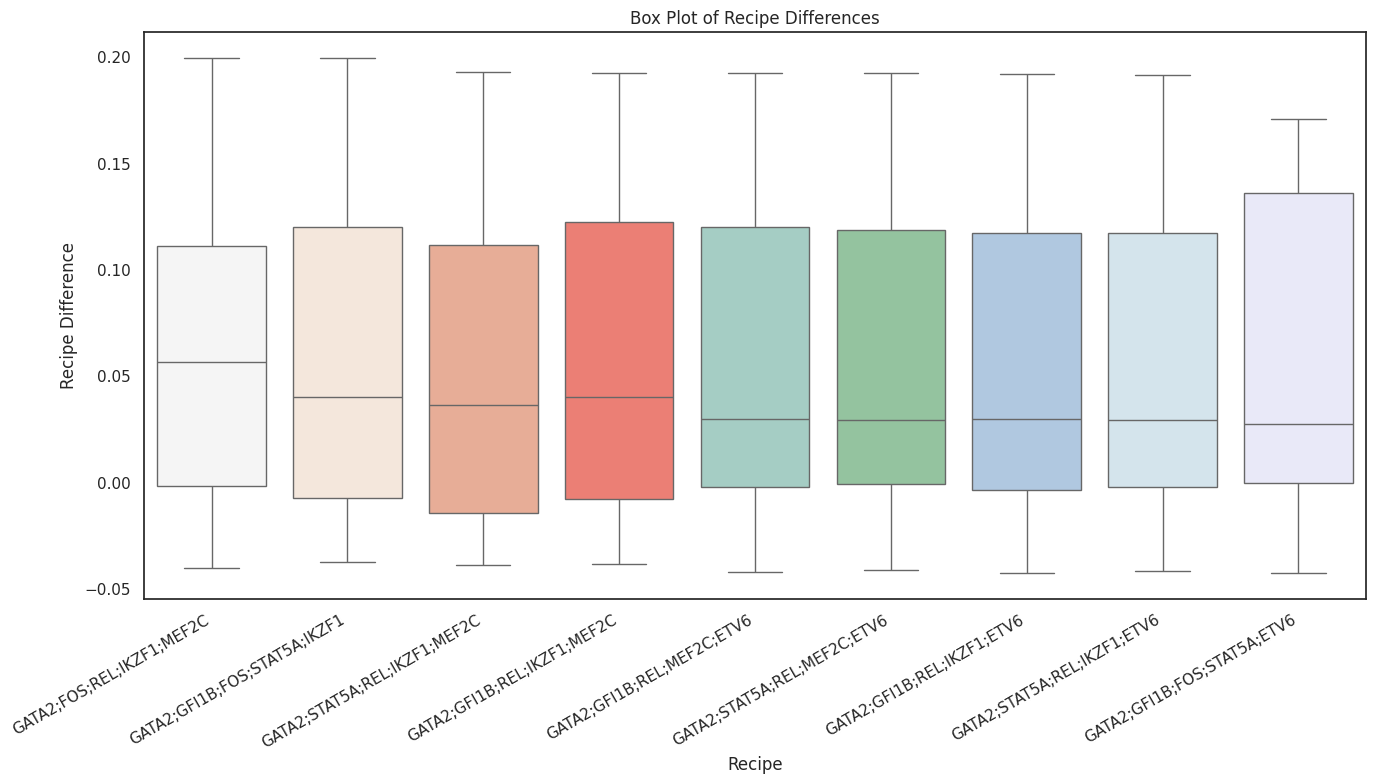

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Define updated custom colors
colors = [
    "#F5F5F5",  # Very Light Cream
    "#F8E6D8",  # Light Warm Cream
    "#F4A78A",  # Light Orange Clay
    "#FF6F61",  # Coral
    "#9FD3C7",  # Soft Mint Green
    "#8CCB9B",  # Spring Green
    "#A8C8E8",  # Muted Sky Blue
    "#D0E6F0",  # Very Light Powder Blue
    "#E6E6FA",  # Lavender
    "#B39DDB",  # Purple
]

# Ensure the number of colors matches the number of unique recipes
unique_recipes = results_high_rdiff['recipe'].unique()
if len(unique_recipes) > len(colors):
    raise ValueError("Not enough colors specified for the number of unique recipes.")

# Create a color mapping
color_map = dict(zip(unique_recipes, colors))

# Create the box plot
plt.figure(figsize=(14, 8))
box_plot = sns.boxplot(x='recipe', y='recipe_diff', data=results_high_rdiff, palette=color_map)

# Rotate x-axis labels for better readability
plt.xticks(rotation=30, ha='right')
plt.title('Box Plot of Recipe Differences')
plt.xlabel('Recipe')
plt.ylabel('Recipe Difference')
plt.tight_layout()  # Adjust layout to fit labels

# Show the plot
plt.show()


## Recipe Diff (|fin-init| - |fin-mid|) / |fin-init|

In [42]:
# Adjusting condensed results for the re-ranking by mean

condensed_results = condensed_results.sort_values(by=('reprog_to_hsc_1', 'mean'), ascending=True)
condensed_results[('rank', '')] = condensed_results[('reprog_to_hsc_1', 'mean')].rank(ascending=True).astype(int)


# Reorder columns to place 'rank' on the left
condensed_results = condensed_results[[('rank', ''),
                                       ('recipe', ''),
                                       ('fib_1_to_reprog_10', 'mean'),
                                       ('fib_1_to_reprog_10', 'std'),
                                       ('reprog_to_hsc_1', 'mean'),
                                       ('reprog_to_hsc_1', 'std'),
                                       ('recipe_diff', 'mean'),
                                       ('recipe_diff', 'std')]]

#condensed_results[('rank','')].max()
condensed_results

# Adjusting results for filtering by these values


rank                        recipe fib_1_to_reprog_10            \
                                                     mean       std   
50     1     GATA2;FOS;REL;IKZF1;MEF2C           0.055854  0.075408   
90     2   GATA2;GFI1B;FOS;STAT5A;ETV6           0.054266  0.062601   
92     3  GATA2;GFI1B;FOS;STAT5A;IKZF1           0.046111  0.066718   
87     4     GATA2;GFI1B;FOS;REL;RUNX3           0.056104  0.073022   
156    5  GATA2;STAT5A;REL;IKZF1;MEF2C           0.052726  0.070804   
..   ...                           ...                ...       ...   
185  248   GFI1B;FOS;STAT5A;FOSB;RUNX3           0.034809  0.046446   
233  249     REL;FOSB;IKZF1;RUNX3;ETV6           0.039998  0.052116   
238  250  STAT5A;FOSB;IKZF1;RUNX3;ETV6           0.035472  0.044132   
234  251    REL;FOSB;IKZF1;RUNX3;MEF2C           0.033622  0.043760   
198  252   GFI1B;FOSB;IKZF1;RUNX3;ETV6           0.033180  0.043130   

    reprog_to_hsc_1           recipe_diff            
               mean       std        mean       std  
50         0.805842  0.067341    0.059285  0.078612  
90         0.807415  0.068167    0.057449  0.079576  
92         0.809019  0.069646    0.055576  0.081303  
87         0.809166  0.066829    0.055405  0.078014  
156        0.809359  0.068392    0.055179  0.079838  
..              ...       ...         ...       ...  
185        0.829751  0.064063    0.031375  0.074785  
233        0.830300  0.062616    0.030733  0.073096  
238        0.831950  0.062766    0.028808  0.073271  
234        0.832393  0.060706    0.028290  0.070866  
198        0.834107  0.060925    0.026289  0.071122  

[252 rows x 8 columns]

In [43]:
condensed_results['reprog_to_hsc_1'].max()

mean    0.834107
std     0.071582
dtype: float64

In [44]:
# add back the names of results column to results
results_df['recipe'] = results_df['cluster_number'].apply(get_reprog_recipe_name)
results_df


,cluster_number,recipe_number,recipe,reprog_to_hsc_1,fib_1_to_reprog_10,recipe_diff
0,607,61,GATA2;FOS;STAT5A;REL;ETV6,0.678985,0.200316,0.207374
1,676,68,GATA2;FOS;STAT5A;IKZF1;ETV6,0.680233,0.186998,0.205917
2,595,60,GATA2;FOS;STAT5A;REL;MEF2C,0.681894,0.200065,0.203978
3,774,78,GATA2;FOS;REL;IKZF1;ETV6,0.682960,0.191363,0.202733
4,163,17,GATA2;GFI1B;FOS;IKZF1;MEF2C,0.683928,0.202149,0.201604
...,...,...,...,...,...,...
2515,2498,250,REL;FOSB;RUNX3;MEF2C;ETV6,0.898876,0.006722,-0.049320
2516,2475,248,REL;FOSB;IKZF1;RUNX3;ETV6,0.899075,0.006540,-0.049552
2517,1942,195,GFI1B;FOSB;RUNX3;MEF2C;ETV6,0.899168,0.009380,-0.049661
2518,2476,248,REL;FOSB;IKZF1;RUNX3;ETV6,0.899506,0.006830,-0.050055


In [45]:
results_df['recipe'].unique()

array(['GATA2;FOS;STAT5A;REL;ETV6', 'GATA2;FOS;STAT5A;IKZF1;ETV6',
       'GATA2;FOS;STAT5A;REL;MEF2C', 'GATA2;FOS;REL;IKZF1;ETV6',
       'GATA2;GFI1B;FOS;IKZF1;MEF2C', 'GATA2;FOS;REL;MEF2C;ETV6',
       'GATA2;GFI1B;FOS;REL;ETV6', 'GATA2;GFI1B;FOS;MEF2C;ETV6',
       'GATA2;GFI1B;FOS;REL;MEF2C', 'GATA2;GFI1B;FOS;IKZF1;ETV6',
       'GFI1B;FOS;STAT5A;REL;IKZF1', 'GATA2;FOS;STAT5A;REL;IKZF1',
       'GATA2;FOS;REL;IKZF1;MEF2C', 'GATA2;GFI1B;FOS;STAT5A;IKZF1',
       'GFI1B;REL;FOSB;IKZF1;MEF2C', 'GATA2;FOS;REL;FOSB;ETV6',
       'GATA2;FOS;STAT5A;IKZF1;MEF2C', 'GFI1B;FOS;STAT5A;IKZF1;MEF2C',
       'GATA2;GFI1B;FOS;REL;IKZF1', 'GATA2;FOS;REL;FOSB;IKZF1',
       'GFI1B;FOS;STAT5A;IKZF1;ETV6', 'GATA2;FOS;IKZF1;MEF2C;ETV6',
       'FOS;STAT5A;REL;IKZF1;ETV6', 'GATA2;GFI1B;FOS;RUNX3;ETV6',
       'GATA2;FOS;REL;FOSB;MEF2C', 'GATA2;FOS;STAT5A;RUNX3;ETV6',
       'GATA2;GFI1B;FOS;STAT5A;FOSB', 'GATA2;GFI1B;FOS;REL;RUNX3',
       'GATA2;GFI1B;FOS;STAT5A;REL', 'GATA2;FOS;REL;IKZF1;RUNX3',
    

In [46]:
# Now that I have ranked results_df, I want to filter out to only have to see the ten with the highest recipe_diff.  I'll just do this manually:

results_df['recipe'] = results_df['recipe'].astype(str)

closest_to_target = condensed_results.loc[condensed_results['rank'].isin(range(1, 11)), 'recipe'].tolist()


results_close_target = results_df[results_df['recipe'].isin(highest_rdiff)]
list1 = results_close_target['recipe'].unique()
list1
# IMPORTANT NOTE: RIGHT NOW                'GATA2;GFI1B;FOS;REL;RUNX',     IS MISSING FROM THE DF!


array(['GATA2;FOS;REL;IKZF1;MEF2C', 'GATA2;GFI1B;FOS;STAT5A;IKZF1',
       'GATA2;STAT5A;REL;IKZF1;MEF2C', 'GATA2;GFI1B;REL;IKZF1;MEF2C',
       'GATA2;GFI1B;REL;MEF2C;ETV6', 'GATA2;STAT5A;REL;MEF2C;ETV6',
       'GATA2;GFI1B;REL;IKZF1;ETV6', 'GATA2;STAT5A;REL;IKZF1;ETV6',
       'GATA2;GFI1B;FOS;STAT5A;ETV6'], dtype=object)

In [47]:
are_equal = list1 == list2
are_equal

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

## Try again

/tmp/ipykernel_344113/796660735.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='recipe', y='recipe_diff', data=results_df[results_df['recipe'].isin(top_recipes)], palette=color_map)


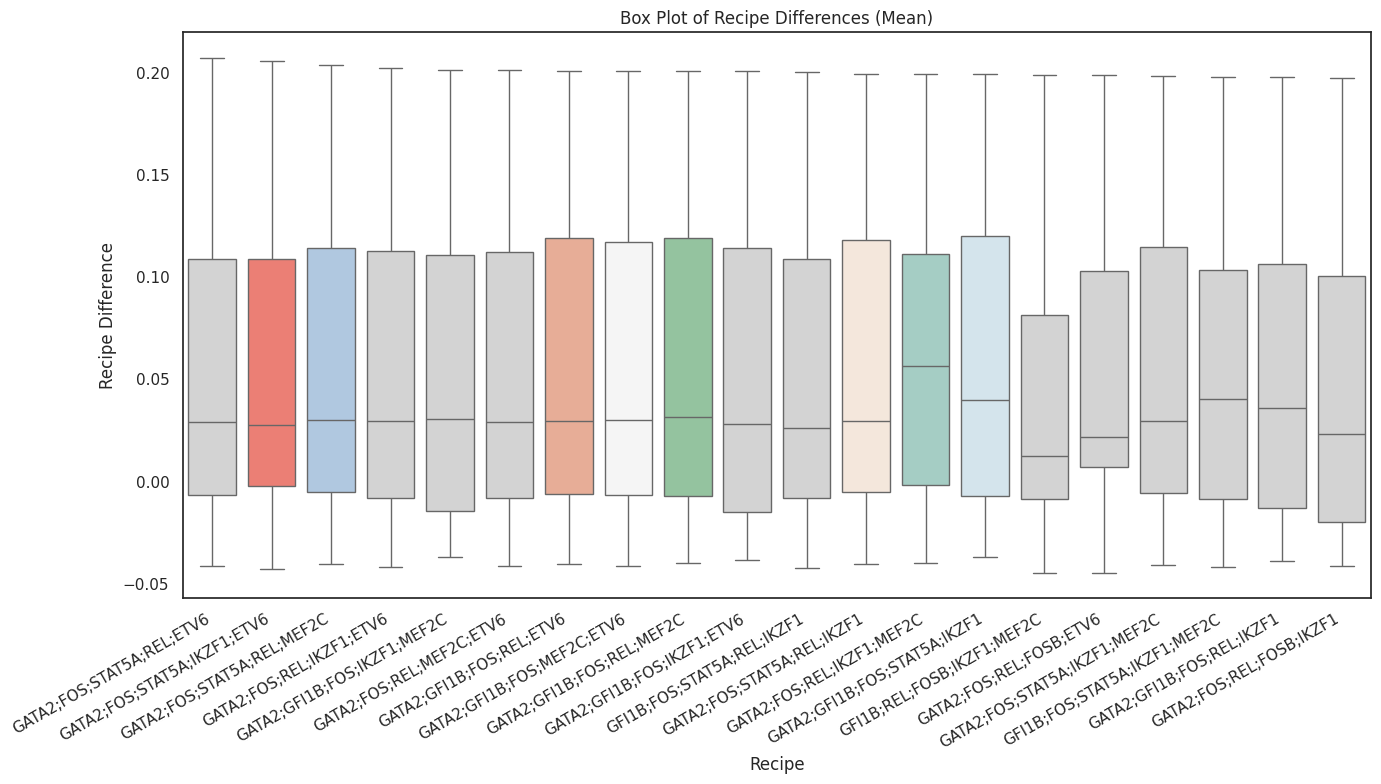

/tmp/ipykernel_344113/796660735.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='recipe', y='recipe_diff', data=results_df[results_df['recipe'].isin(top_recipes)], palette=color_map)


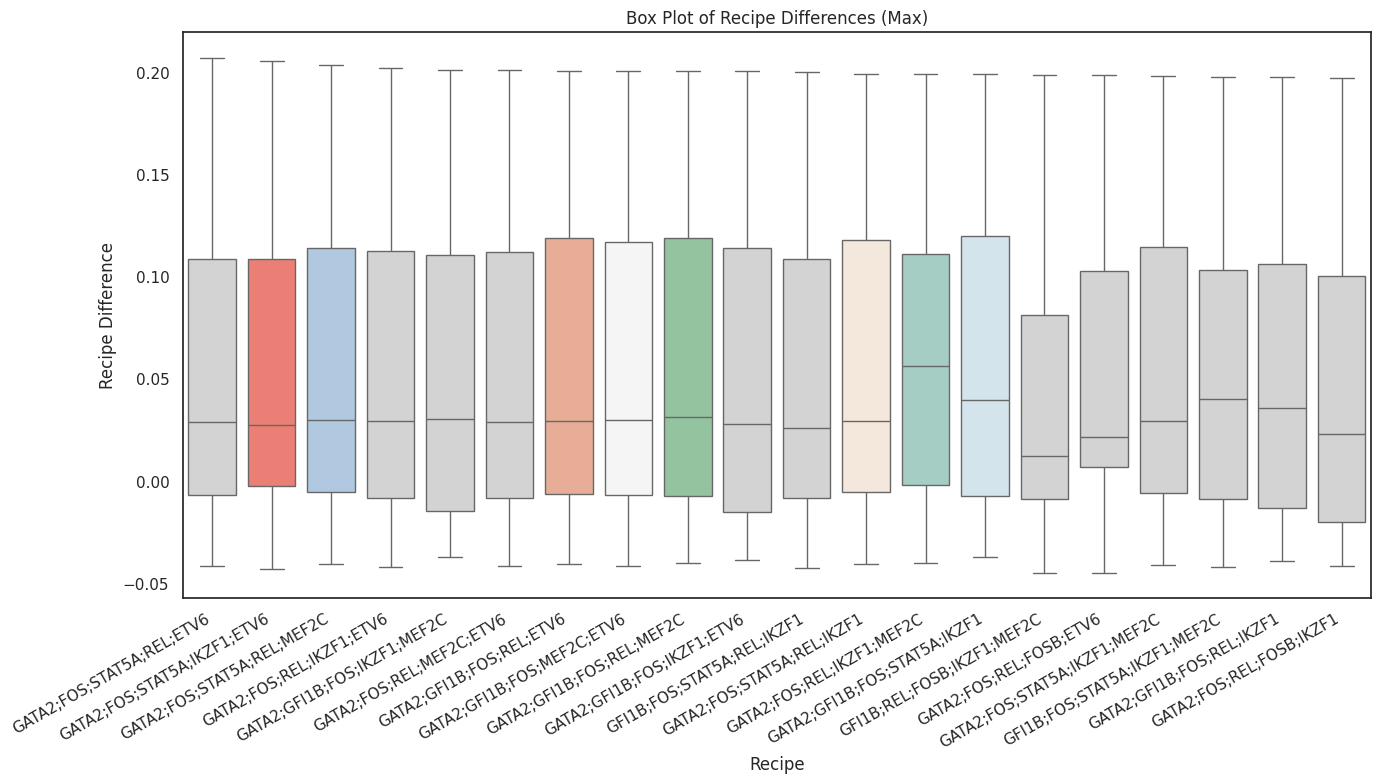

Recipe 'GATA2;FOS;REL;IKZF1;MEF2C' appeared in multiple loops with the following ranks: mean: rank 1, max: rank 13
Recipe 'GATA2;GFI1B;FOS;STAT5A;IKZF1' appeared in multiple loops with the following ranks: mean: rank 3, max: rank 14
Recipe 'GATA2;GFI1B;FOS;REL;MEF2C' appeared in multiple loops with the following ranks: mean: rank 12, max: rank 9
Recipe 'GATA2;FOS;STAT5A;REL;MEF2C' appeared in multiple loops with the following ranks: mean: rank 14, max: rank 3
Recipe 'GATA2;FOS;STAT5A;REL;IKZF1' appeared in multiple loops with the following ranks: mean: rank 15, max: rank 12
Recipe 'GATA2;GFI1B;FOS;REL;ETV6' appeared in multiple loops with the following ranks: mean: rank 18, max: rank 7
Recipe 'GATA2;FOS;STAT5A;IKZF1;ETV6' appeared in multiple loops with the following ranks: mean: rank 19, max: rank 2
Recipe 'GATA2;GFI1B;FOS;MEF2C;ETV6' appeared in multiple loops with the following ranks: mean: rank 20, max: rank 8


In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def create_plots(results_df, stats, colors, init_to_fin_dist):
    # Add 'recipe_diff' column to results_df
    results_df['recipe_diff'] = (init_to_fin_dist - results_df['reprog_to_hsc_1']) / init_to_fin_dist
    
    # Group by 'recipe' and calculate specified statistics for columns
    condensed_results = results_df.groupby('recipe').agg({
        'fib_1_to_reprog_10': stats,
        'reprog_to_hsc_1': stats,
        'recipe_diff': stats
    }).reset_index()

    # Initialize a dictionary to store recipes and their ranks for each statistic
    recipe_lists = defaultdict(dict)

    for idx, stat in enumerate(stats):
        # Sort and rank the results
        condensed_results = condensed_results.sort_values(by=('recipe_diff', stat), ascending=False)
        condensed_results[('rank', '')] = condensed_results[('recipe_diff', stat)].rank(ascending=False).astype(int)

        # Reorder columns to place 'rank' on the left
        columns = [('rank', '')] + [col for col in condensed_results.columns if col != ('rank', '')]
        condensed_results = condensed_results[columns]

        # Filter by top 10 recipes according to current criteria
        results_df['recipe'] = results_df['recipe'].astype(str)
        top_recipes = condensed_results.loc[condensed_results[('rank', '')].isin(range(1, 21)), 'recipe']
        
        # Store recipes and their ranks
        for recipe in top_recipes:
            recipe_lists[recipe][stat] = condensed_results.loc[condensed_results['recipe'] == recipe, ('rank', '')].values[0]

    # Compute the color mapping once for all recipes
    overlapping_recipes = {recipe for recipe, ranks in recipe_lists.items() if len(ranks) > 1}
    all_recipes = results_df['recipe'].unique()
    color_map = {recipe: colors[i % len(colors)] for i, recipe in enumerate(overlapping_recipes)}
    color_map.update({recipe: "#D3D3D3" for recipe in all_recipes if recipe not in overlapping_recipes})

    # Create box plots with consistent color mapping
    for idx, stat in enumerate(stats):
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='recipe', y='recipe_diff', data=results_df[results_df['recipe'].isin(top_recipes)], palette=color_map)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=30, ha='right')
        plt.title(f'Box Plot of Recipe Differences ({stat.capitalize()})')
        plt.xlabel('Recipe')
        plt.ylabel('Recipe Difference')
        plt.tight_layout()  # Adjust layout to fit labels
        
        # Show the plot
        plt.show()

    return recipe_lists

def print_list_overlaps(recipe_lists):
    # Print recipes that appear in more than one loop with their ranks
    found = False
    for recipe, ranks in recipe_lists.items():
        if len(ranks) > 1:
            ranks_str = ", ".join([f"{stat}: rank {rank}" for stat, rank in ranks.items()])
            print(f"Recipe '{recipe}' appeared in multiple loops with the following ranks: {ranks_str}")
            found = True

    if not found:
        print("No recipes appeared in multiple loops.")

# Example usage
init_to_fin_dist = 0.85662723
colors = [
    "#F5F5F5",  # Very Light Cream
    "#F8E6D8",  # Light Warm Cream
    "#F4A78A",  # Light Orange Clay
    "#FF6F61",  # Coral
    "#9FD3C7",  # Soft Mint Green
    "#8CCB9B",  # Spring Green
    "#A8C8E8",  # Muted Sky Blue
    "#D0E6F0",  # Very Light Powder Blue
    "#E6E6FA",  # Lavender
    "#B39DDB",  # Purple
]
stats = ['mean', 'max']

# Assuming results_df is already defined
recipe_lists = create_plots(results_df, stats, colors, init_to_fin_dist)
print_list_overlaps(recipe_lists)


/tmp/ipykernel_344113/1230870176.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='recipe', y='recipe_diff', data=plotting_results_df, palette=color_map,


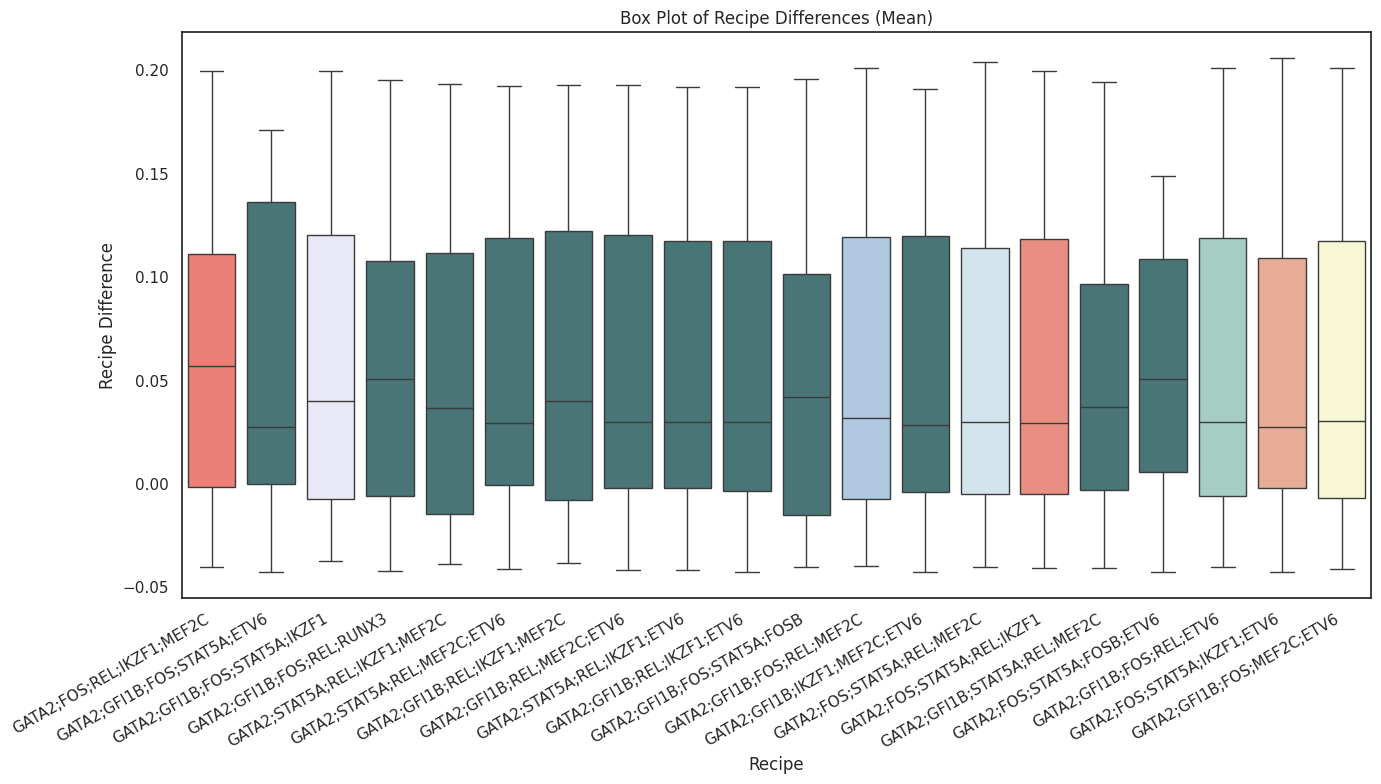

/tmp/ipykernel_344113/1230870176.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='recipe', y='recipe_diff', data=plotting_results_df, palette=color_map,


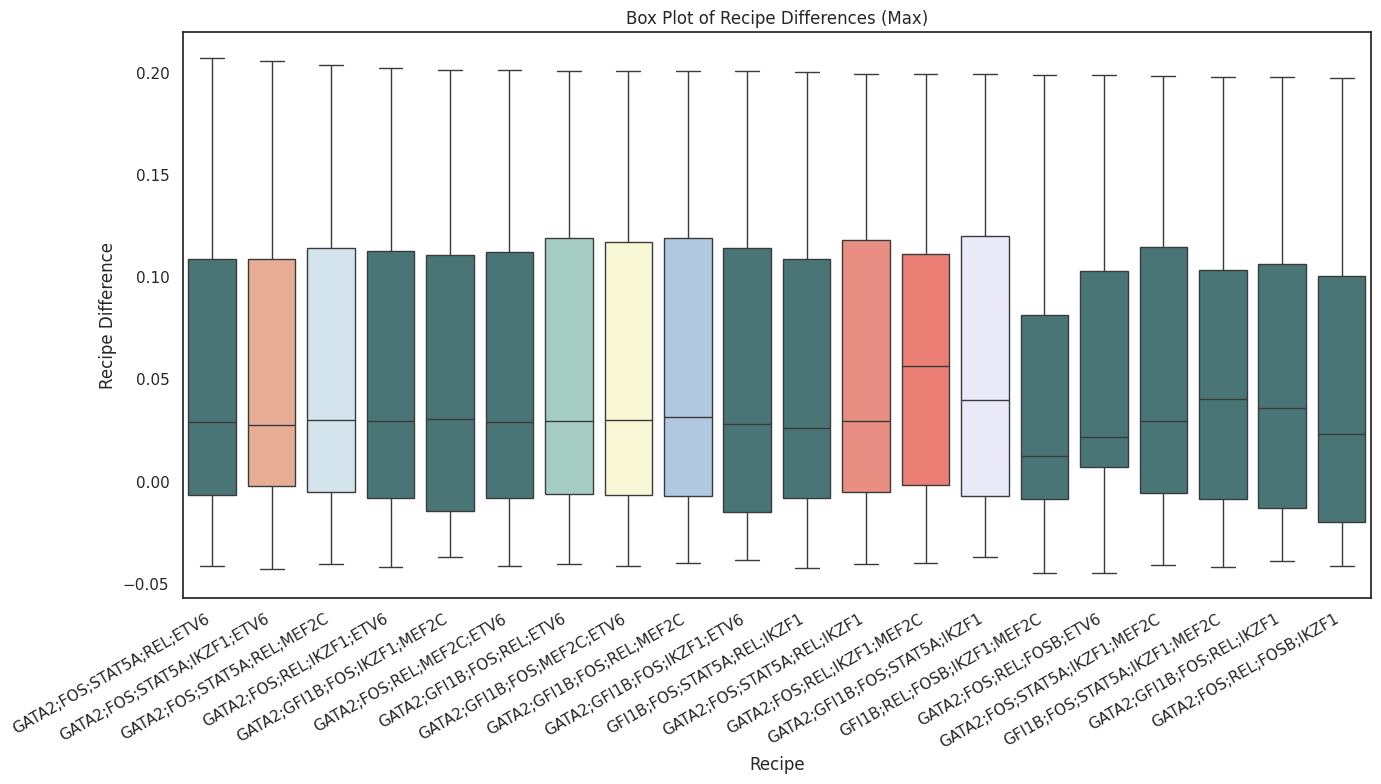

Recipe 'GATA2;FOS;REL;IKZF1;MEF2C' appeared in multiple loops with the following ranks: mean: rank 1, max: rank 13
Recipe 'GATA2;FOS;STAT5A;IKZF1;ETV6' appeared in multiple loops with the following ranks: mean: rank 19, max: rank 2
Recipe 'GATA2;FOS;STAT5A;REL;IKZF1' appeared in multiple loops with the following ranks: mean: rank 15, max: rank 12
Recipe 'GATA2;FOS;STAT5A;REL;MEF2C' appeared in multiple loops with the following ranks: mean: rank 14, max: rank 3
Recipe 'GATA2;GFI1B;FOS;MEF2C;ETV6' appeared in multiple loops with the following ranks: mean: rank 20, max: rank 8
Recipe 'GATA2;GFI1B;FOS;REL;ETV6' appeared in multiple loops with the following ranks: mean: rank 18, max: rank 7
Recipe 'GATA2;GFI1B;FOS;REL;MEF2C' appeared in multiple loops with the following ranks: mean: rank 12, max: rank 9
Recipe 'GATA2;GFI1B;FOS;STAT5A;IKZF1' appeared in multiple loops with the following ranks: mean: rank 3, max: rank 14


In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def create_plots(results_df, stats, colors, init_to_fin_dist):
    # Add 'recipe_diff' column to results_df
    results_df['recipe_diff'] = (init_to_fin_dist - results_df['reprog_to_hsc_1']) / init_to_fin_dist
    
    # Initialize a dictionary to store recipes and their ranks for each statistic
    recipe_lists = defaultdict(dict)
    
    for stat in stats:
        # Group by 'recipe' and calculate specified statistics for columns
        condensed_results = results_df.groupby('recipe').agg({
            'fib_1_to_reprog_10': stat,
            'reprog_to_hsc_1': stat,
            'recipe_diff': stat
        }).reset_index()
        
        # Sort and rank the results
        condensed_results['rank'] = condensed_results['recipe_diff'].rank(ascending=False).astype(int)
        
        # Filter by top 20 recipes according to current criteria
        top_recipes = condensed_results[condensed_results['rank'] <= 20]
        
        # Store recipes and their ranks
        for recipe in top_recipes['recipe']:
            recipe_lists[recipe][stat] = top_recipes[top_recipes['recipe'] == recipe]['rank'].values[0]
    
    # Determine overlapping recipes
    overlapping_recipes = {recipe for recipe, ranks in recipe_lists.items() if len(ranks) > 1}
    
    # Prepare color mapping
    non_gray_colors = colors[1:]  # Exclude gray color
    num_colors = len(non_gray_colors)
    color_map = {recipe: non_gray_colors[i % num_colors] for i, recipe in enumerate(overlapping_recipes)}
    color_map.update({recipe: "#427c7e" for recipe in results_df['recipe'].unique() if recipe not in overlapping_recipes})
    
    # Create box plots with consistent color mapping
    for stat in stats:
        # Group by 'recipe' and calculate specified statistics for columns
        condensed_results = results_df.groupby('recipe').agg({
            'fib_1_to_reprog_10': stat,
            'reprog_to_hsc_1': stat,
            'recipe_diff': stat
        }).reset_index()
        
        # Sort and rank the results
        condensed_results['rank'] = condensed_results['recipe_diff'].rank(ascending=False).astype(int)
        
        # Filter by top 20 recipes according to current criteria
        top_recipes = condensed_results[condensed_results['rank'] <= 20]
        # Sort recipes by their rank for plotting
        sorted_recipes = top_recipes.sort_values(by='rank')['recipe']
        
        # Prepare the DataFrame for plotting with sorted recipes
        plotting_results_df = results_df[results_df['recipe'].isin(sorted_recipes)]
        
        #Create the box plot
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='recipe', y='recipe_diff', data=plotting_results_df, palette=color_map, 
                    order=sorted_recipes)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=30, ha='right')
        
        
        plt.title(f'Box Plot of Recipe Differences ({stat.capitalize()})')
        plt.xlabel('Recipe')
        plt.ylabel('Recipe Difference')
        plt.tight_layout()  # Adjust layout to fit labels
        
        # Show the plot
        plt.show()




    
    return recipe_lists

def print_list_overlaps(recipe_lists):
    # Print recipes that appear in more than one loop with their ranks
    found = False
    for recipe, ranks in recipe_lists.items():
        if len(ranks) > 1:
            ranks_str = ", ".join([f"{stat}: rank {rank}" for stat, rank in ranks.items()])
            print(f"Recipe '{recipe}' appeared in multiple loops with the following ranks: {ranks_str}")
            found = True

    if not found:
        print("No recipes appeared in multiple loops.")

# Example usage
init_to_fin_dist = 0.85662723
colors =  [
    "#2C3E50",  # Storm Gray (Neutral)
    "#FFFDD0",  # Cream
    "#FA8072",  # Salmon Pink
    "#9FD3C7",  # Soft Mint Green
    "#F4A78A",  # Light Orange Clay
    "#FF6F61",  # Coral
    "#A8C8E8",  # Muted Sky Blue
    "#D0E6F0",  # Very Light Powder Blue
    "#E6E6FA",  # Lavender
    "#B39DDB",  # Purple
]

# Assuming `colors` list is used in the `create_plots` function as the `colors` argument

stats = ['mean', 'max']

# Assuming results_df is already defined
recipe_lists = create_plots(results_df, stats, colors, init_to_fin_dist)
print_list_overlaps(recipe_lists)


/tmp/ipykernel_344113/956666533.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='recipe', y='recipe_diff', data=plotting_results_df, palette=color_map,


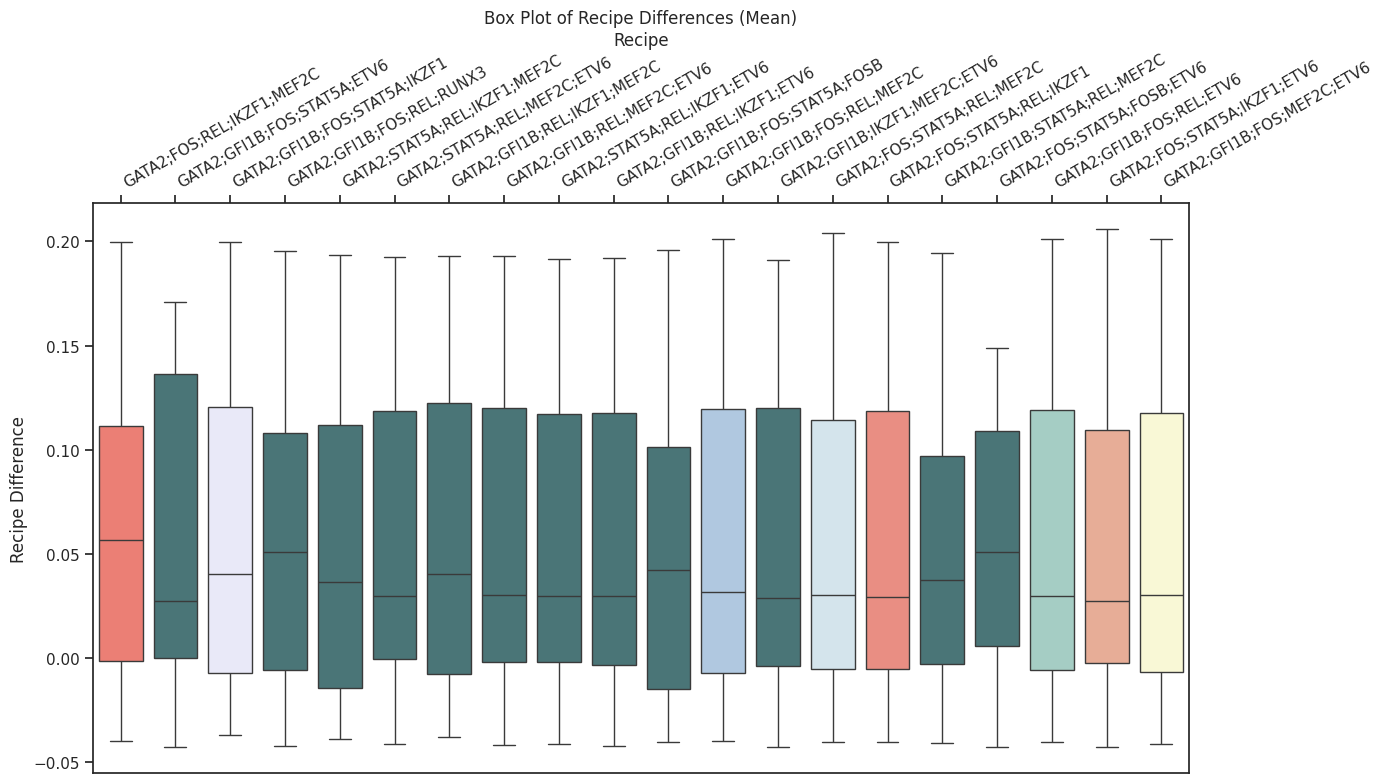

/tmp/ipykernel_344113/956666533.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='recipe', y='recipe_diff', data=plotting_results_df, palette=color_map,


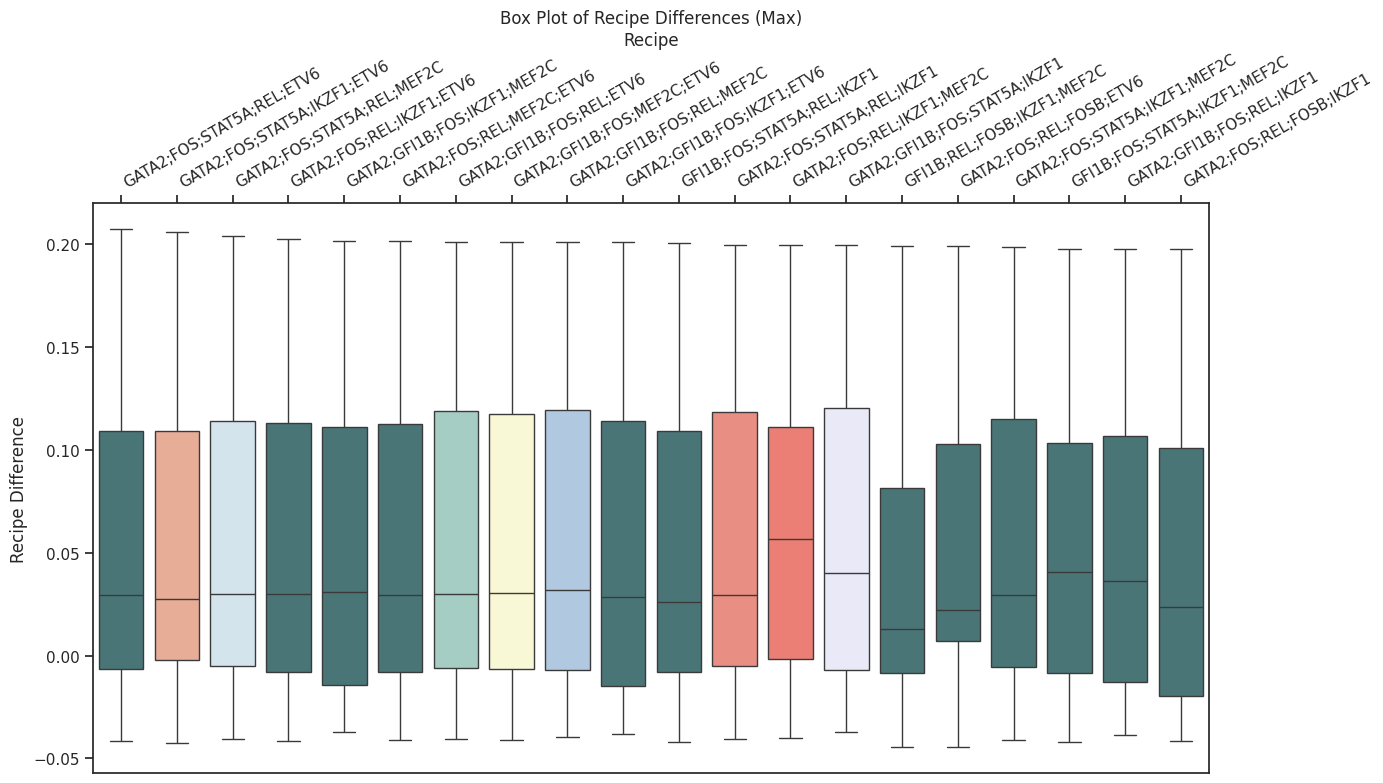

Recipe 'GATA2;FOS;REL;IKZF1;MEF2C' appeared in multiple loops with the following ranks: mean: rank 1, max: rank 13
Recipe 'GATA2;FOS;STAT5A;IKZF1;ETV6' appeared in multiple loops with the following ranks: mean: rank 19, max: rank 2
Recipe 'GATA2;FOS;STAT5A;REL;IKZF1' appeared in multiple loops with the following ranks: mean: rank 15, max: rank 12
Recipe 'GATA2;FOS;STAT5A;REL;MEF2C' appeared in multiple loops with the following ranks: mean: rank 14, max: rank 3
Recipe 'GATA2;GFI1B;FOS;MEF2C;ETV6' appeared in multiple loops with the following ranks: mean: rank 20, max: rank 8
Recipe 'GATA2;GFI1B;FOS;REL;ETV6' appeared in multiple loops with the following ranks: mean: rank 18, max: rank 7
Recipe 'GATA2;GFI1B;FOS;REL;MEF2C' appeared in multiple loops with the following ranks: mean: rank 12, max: rank 9
Recipe 'GATA2;GFI1B;FOS;STAT5A;IKZF1' appeared in multiple loops with the following ranks: mean: rank 3, max: rank 14


In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def create_plots(results_df, stats, colors, init_to_fin_dist):
    # Add 'recipe_diff' column to results_df
    results_df['recipe_diff'] = (init_to_fin_dist - results_df['reprog_to_hsc_1']) / init_to_fin_dist
    
    # Initialize a dictionary to store recipes and their ranks for each statistic
    recipe_lists = defaultdict(dict)
    
    for stat in stats:
        # Group by 'recipe' and calculate specified statistics for columns
        condensed_results = results_df.groupby('recipe').agg({
            'fib_1_to_reprog_10': stat,
            'reprog_to_hsc_1': stat,
            'recipe_diff': stat
        }).reset_index()
        
        # Sort and rank the results
        condensed_results['rank'] = condensed_results['recipe_diff'].rank(ascending=False).astype(int)
        
        # Filter by top 20 recipes according to current criteria
        top_recipes = condensed_results[condensed_results['rank'] <= 20]
        
        # Store recipes and their ranks
        for recipe in top_recipes['recipe']:
            recipe_lists[recipe][stat] = top_recipes[top_recipes['recipe'] == recipe]['rank'].values[0]
    
    # Determine overlapping recipes
    overlapping_recipes = {recipe for recipe, ranks in recipe_lists.items() if len(ranks) > 1}
    
    # Prepare color mapping
    non_gray_colors = colors[1:]  # Exclude gray color
    num_colors = len(non_gray_colors)
    color_map = {recipe: non_gray_colors[i % num_colors] for i, recipe in enumerate(overlapping_recipes)}
    color_map.update({recipe: "#427c7e" for recipe in results_df['recipe'].unique() if recipe not in overlapping_recipes})
    
    # Create box plots with consistent color mapping
    for stat in stats:
        # Group by 'recipe' and calculate specified statistics for columns
        condensed_results = results_df.groupby('recipe').agg({
            'fib_1_to_reprog_10': stat,
            'reprog_to_hsc_1': stat,
            'recipe_diff': stat
        }).reset_index()
        
        # Sort and rank the results
        condensed_results['rank'] = condensed_results['recipe_diff'].rank(ascending=False).astype(int)
        
        # Filter by top 20 recipes according to current criteria
        top_recipes = condensed_results[condensed_results['rank'] <= 20]
        # Sort recipes by their rank for plotting
        sorted_recipes = top_recipes.sort_values(by='rank')['recipe']
        
        # Prepare the DataFrame for plotting with sorted recipes
        plotting_results_df = results_df[results_df['recipe'].isin(sorted_recipes)]
        
        #Create the box plot
        plt.figure(figsize=(14, 8))
        ax = sns.boxplot(x='recipe', y='recipe_diff', data=plotting_results_df, palette=color_map, 
                    order=sorted_recipes)
        



        
        
        # Move ticks to the top and left
        ax.xaxis.set_ticks_position('top')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_label_position('top')
        ax.yaxis.set_label_position('left')
        ax.xaxis.tick_top()
        ax.yaxis.tick_left()
        
        # Adjust the tick parameters for better visibility
        ax.tick_params(axis='x', top=True, bottom=False)
        ax.tick_params(axis='y', left=True, right=False)


        # Rotate x-axis labels for better readability
        plt.xticks(rotation=30, ha='left')





        
        plt.title(f'Box Plot of Recipe Differences ({stat.capitalize()})')
        plt.xlabel('Recipe')
        plt.ylabel('Recipe Difference')
        plt.tight_layout()  # Adjust layout to fit labels
        
        # Show the plot
        plt.show()



        

    
    return recipe_lists

def print_list_overlaps(recipe_lists):
    # Print recipes that appear in more than one loop with their ranks
    found = False
    for recipe, ranks in recipe_lists.items():
        if len(ranks) > 1:
            ranks_str = ", ".join([f"{stat}: rank {rank}" for stat, rank in ranks.items()])
            print(f"Recipe '{recipe}' appeared in multiple loops with the following ranks: {ranks_str}")
            found = True

    if not found:
        print("No recipes appeared in multiple loops.")

# Example usage
init_to_fin_dist = 0.85662723
colors =  [
    "#2C3E50",  # Storm Gray (Neutral)
    "#FFFDD0",  # Cream
    "#FA8072",  # Salmon Pink
    "#9FD3C7",  # Soft Mint Green
    "#F4A78A",  # Light Orange Clay
    "#FF6F61",  # Coral
    "#A8C8E8",  # Muted Sky Blue
    "#D0E6F0",  # Very Light Powder Blue
    "#E6E6FA",  # Lavender
    "#B39DDB",  # Purple
]

# Assuming `colors` list is used in the `create_plots` function as the `colors` argument

stats = ['mean', 'max']

# Assuming results_df is already defined
recipe_lists = create_plots(results_df, stats, colors, init_to_fin_dist)
print_list_overlaps(recipe_lists)


/tmp/ipykernel_344113/397798160.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='recipe', y='recipe_diff', data=plotting_results_df, palette=color_map,


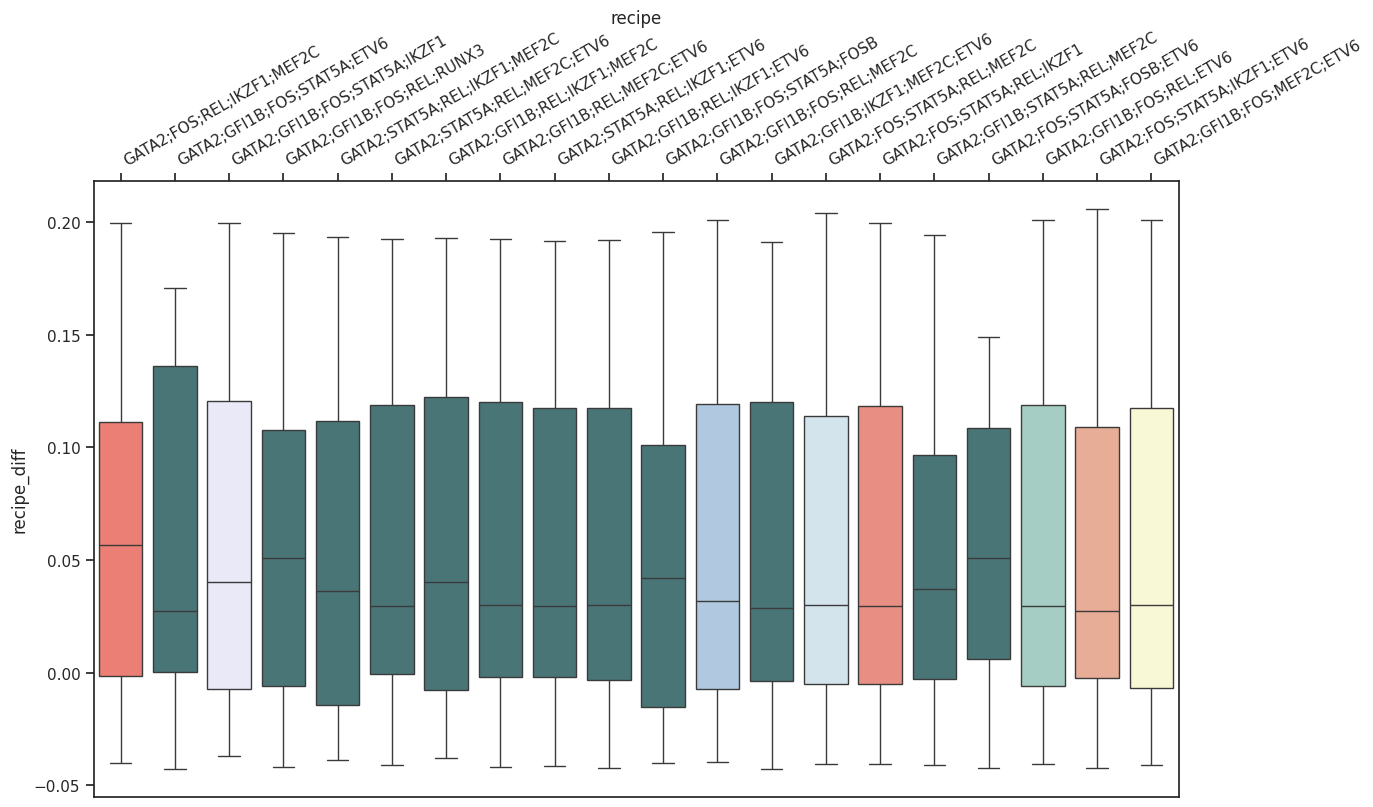

/tmp/ipykernel_344113/397798160.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='recipe', y='recipe_diff', data=plotting_results_df, palette=color_map,


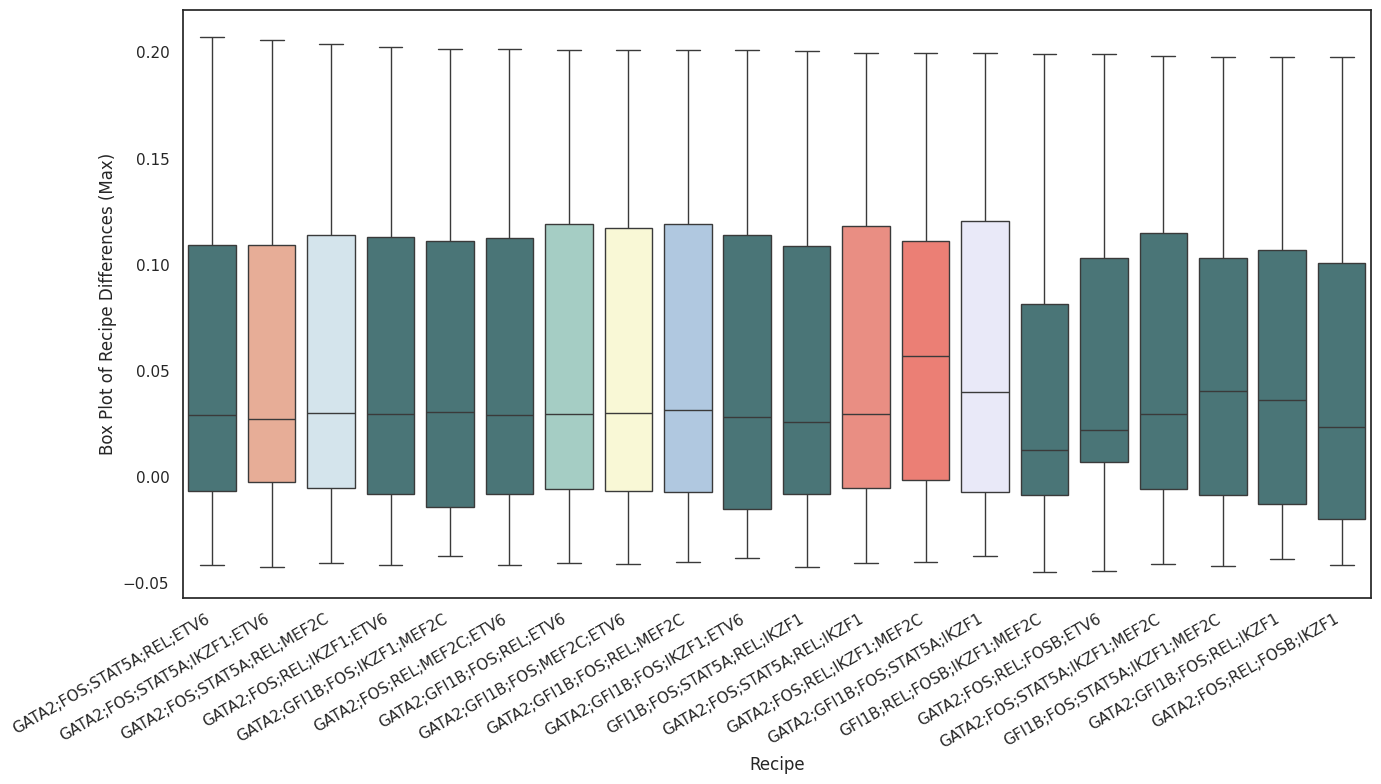

Recipe 'GATA2;FOS;REL;IKZF1;MEF2C' appeared in multiple loops with the following ranks: mean: rank 1, max: rank 13
Recipe 'GATA2;FOS;STAT5A;IKZF1;ETV6' appeared in multiple loops with the following ranks: mean: rank 19, max: rank 2
Recipe 'GATA2;FOS;STAT5A;REL;IKZF1' appeared in multiple loops with the following ranks: mean: rank 15, max: rank 12
Recipe 'GATA2;FOS;STAT5A;REL;MEF2C' appeared in multiple loops with the following ranks: mean: rank 14, max: rank 3
Recipe 'GATA2;GFI1B;FOS;MEF2C;ETV6' appeared in multiple loops with the following ranks: mean: rank 20, max: rank 8
Recipe 'GATA2;GFI1B;FOS;REL;ETV6' appeared in multiple loops with the following ranks: mean: rank 18, max: rank 7
Recipe 'GATA2;GFI1B;FOS;REL;MEF2C' appeared in multiple loops with the following ranks: mean: rank 12, max: rank 9
Recipe 'GATA2;GFI1B;FOS;STAT5A;IKZF1' appeared in multiple loops with the following ranks: mean: rank 3, max: rank 14


In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def create_plots(results_df, stats, colors, init_to_fin_dist):
    # Add 'recipe_diff' column to results_df
    results_df['recipe_diff'] = (init_to_fin_dist - results_df['reprog_to_hsc_1']) / init_to_fin_dist
    
    # Initialize a dictionary to store recipes and their ranks for each statistic
    recipe_lists = defaultdict(dict)
    
    for stat in stats:
        # Group by 'recipe' and calculate specified statistics for columns
        condensed_results = results_df.groupby('recipe').agg({
            'fib_1_to_reprog_10': stat,
            'reprog_to_hsc_1': stat,
            'recipe_diff': stat
        }).reset_index()
        
        # Sort and rank the results
        condensed_results['rank'] = condensed_results['recipe_diff'].rank(ascending=False).astype(int)
        
        # Filter by top 20 recipes according to current criteria
        top_recipes = condensed_results[condensed_results['rank'] <= 20]
        
        # Store recipes and their ranks
        for recipe in top_recipes['recipe']:
            recipe_lists[recipe][stat] = top_recipes[top_recipes['recipe'] == recipe]['rank'].values[0]
    
    # Determine overlapping recipes
    overlapping_recipes = {recipe for recipe, ranks in recipe_lists.items() if len(ranks) > 1}
    
    # Prepare color mapping
    non_gray_colors = colors[1:]  # Exclude gray color
    num_colors = len(non_gray_colors)
    color_map = {recipe: non_gray_colors[i % num_colors] for i, recipe in enumerate(overlapping_recipes)}
    color_map.update({recipe: "#427c7e" for recipe in results_df['recipe'].unique() if recipe not in overlapping_recipes})
    
    # List of horizontal alignment values corresponding to each statistic
    ha_values = ['left', 'right']
    
    # Create box plots with consistent color mapping
    for i, stat in enumerate(stats):
        # Group by 'recipe' and calculate specified statistics for columns
        condensed_results = results_df.groupby('recipe').agg({
            'fib_1_to_reprog_10': stat,
            'reprog_to_hsc_1': stat,
            'recipe_diff': stat
        }).reset_index()
        
        # Sort and rank the results
        condensed_results['rank'] = condensed_results['recipe_diff'].rank(ascending=False).astype(int)
        
        # Filter by top 20 recipes according to current criteria
        top_recipes = condensed_results[condensed_results['rank'] <= 20]
        # Sort recipes by their rank for plotting
        sorted_recipes = top_recipes.sort_values(by='rank')['recipe']
        
        # Prepare the DataFrame for plotting with sorted recipes
        plotting_results_df = results_df[results_df['recipe'].isin(sorted_recipes)]


        if ha_values[i] == 'left':
            #Create the box plot
            plt.figure(figsize=(14, 8))
            ax = sns.boxplot(x='recipe', y='recipe_diff', data=plotting_results_df, palette=color_map, 
                        order=sorted_recipes)

            # Move ticks to the top and left
            ax.xaxis.set_ticks_position('top')
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_label_position('top')
            ax.yaxis.set_label_position('left')
            ax.xaxis.tick_top()
            ax.yaxis.tick_left()
            
            # Adjust the tick parameters for better visibility
            ax.tick_params(axis='x', top=True, bottom=False)
            ax.tick_params(axis='y', left=True, right=False)
    
    
            # Rotate x-axis labels for better readability
            plt.xticks(rotation=30, ha='left')
            
            plt.show()
        else:
            #Create the box plot
            plt.figure(figsize=(14, 8))
            sns.boxplot(x='recipe', y='recipe_diff', data=plotting_results_df, palette=color_map, 
                        order=sorted_recipes)
            
            # Rotate x-axis labels for better readability
            plt.xticks(rotation=30, ha='right')
            
            
            #plt.title(f'Box Plot of Recipe Differences ({stat.capitalize()})')
            plt.xlabel('Recipe')
            plt.ylabel(f'Box Plot of Recipe Differences ({stat.capitalize()})')
            plt.tight_layout()  # Adjust layout to fit labels
            
            # Show the plot
            plt.show()


    return recipe_lists

def print_list_overlaps(recipe_lists):
    # Print recipes that appear in more than one loop with their ranks
    found = False
    for recipe, ranks in recipe_lists.items():
        if len(ranks) > 1:
            ranks_str = ", ".join([f"{stat}: rank {rank}" for stat, rank in ranks.items()])
            print(f"Recipe '{recipe}' appeared in multiple loops with the following ranks: {ranks_str}")
            found = True

    if not found:
        print("No recipes appeared in multiple loops.")

# Example usage
init_to_fin_dist = 0.85662723
colors =  [
    "#2C3E50",  # Storm Gray (Neutral)
    "#FFFDD0",  # Cream
    "#FA8072",  # Salmon Pink
    "#9FD3C7",  # Soft Mint Green
    "#F4A78A",  # Light Orange Clay
    "#FF6F61",  # Coral
    "#A8C8E8",  # Muted Sky Blue
    "#D0E6F0",  # Very Light Powder Blue
    "#E6E6FA",  # Lavender
    "#B39DDB",  # Purple
]

# Assuming `colors` list is used in the `create_plots` function as the `colors` argument

stats = ['mean', 'max']

# Assuming results_df is already defined
recipe_lists = create_plots(results_df, stats, colors, init_to_fin_dist)
print_list_overlaps(recipe_lists)
